# Comparison with GroundTruth

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt

import skimage.io
import skimage.color
import skimage.transform
import skimage.morphology
import torch

from typing import List, Tuple
from typing import Optional
import numpy
from MODULES.namedtuple import Partition

### Helper functions

In [3]:
def contours_from_labels(labels, thickness: int=1):
    contours = (skimage.morphology.dilation(labels)  != labels)
    for i in range(1,thickness):
        contours = skimage.morphology.binary_dilation(contours)
    return contours

def add_red_contours(image, contours):
    assert image.shape[:2] == contours.shape[:2]
    my_max = numpy.max(image)
    if len(image.shape) == 2:
        image = numpy.repeat(image[..., None], 3, axis=-1)
    assert len(image.shape)== 3 # w,h,ch
    assert image.shape[-1] == 3 # 3 channels
    image[contours, 0] = my_max
    image[contours, 1:] = 0
    return image



def make_list_of_windows(ROI_mask: numpy.ndarray, n: int = 4, crop_size: int = 80):
    delta = 200
    window = list()
    while len(window)<n:
        iw = numpy.random.randint(low=0, high=ROI_mask.shape[0]-crop_size, size=1, dtype=int).item()
        ih = numpy.random.randint(low=0, high=ROI_mask.shape[1]-crop_size, size=1, dtype=int).item()
        if (ROI_mask[iw,ih] == 0) and (ROI_mask[iw+crop_size,ih] == 0) and \
           (ROI_mask[iw,ih+crop_size] == 0) and (ROI_mask[iw+crop_size,ih+crop_size] == 0):
            continue
        else:
            window.append((iw,ih,iw+crop_size,ih+crop_size))
    return window


def plot_comparison(raw_img, labels1, labels2, window: Optional[List[tuple]] = None, figsize: tuple =(24,24)):
    if window is None:
        window = [[0,0,img1.shape[0],img1.shape[1]]]
    
    n = len(window)
    if n>1:
        fig, axs = plt.subplots(nrows=n, ncols=2, figsize=figsize)
    else:
        fig, axs = plt.subplots(ncols=2, figsize=figsize)
        
    for row,w in enumerate(window):
        img = raw_img[w[0]:w[2],w[1]:w[3]]
        l1 = labels1[w[0]:w[2],w[1]:w[3]]
        l2 = labels2[w[0]:w[2],w[1]:w[3]]
        c1 = contours_from_labels(l1, thickness=3)
        c2 = contours_from_labels(l2, thickness=3)
        tmp1 = add_red_contours(img, c1)
        tmp2 = add_red_contours(img, c2)
        # print(tmp1.dtype, img.dtype)

        if n>1:
            axs[row,0].imshow(tmp1, aspect='equal')
            axs[row,1].imshow(tmp2, aspect='equal')
        else:
            axs[0].imshow(tmp1, aspect='equal')
            axs[1].imshow(tmp2, aspect='equal')
            

def make_and_save_segmentation(file_name, labels, raw_image):
    assert labels.shape[:2] == raw_image.shape[:2]
    c = contours_from_labels(labels=labels, thickness=3)
    tmp = add_red_contours(image=skimage.img_as_ubyte(raw_image), contours=c)
    print(tmp.shape, tmp.dtype)
    skimage.io.imsave(file_name, tmp)

### Open the files

In [4]:
image_file = "smFISH_stitched_OLEH.tif"
oleh_file = "smFISH-full_result_mask.tif"
luca_file = "segmentation_res800.tiff"
gt_file = "manual_annotation_aligned.tif"

raw_img = skimage.img_as_ubyte(skimage.exposure.rescale_intensity(skimage.io.imread(image_file)))
luca_small = skimage.io.imread(luca_file).astype(numpy.uint16)
oleh_img = skimage.io.imread(oleh_file).astype(numpy.uint16)
gt_img = skimage.io.imread(gt_file).astype(numpy.uint16)


# gt_file_transpose = "segmentation_labels_from_json_transposed.tiff"
#dx=50
#dy=-100
#gt_img = skimage.io.imread(gt_file_transpose).astype(numpy.uint16).T
#gt_shifted = numpy.roll(numpy.roll(gt_img, dx, axis=0), dy, axis=1)[-raw_img.shape[0]:,:raw_img.shape[1]]
#skimage.io.imsave("manual_annotation_aligned.tif", gt_shifted, plugin=None, check_contrast=True)

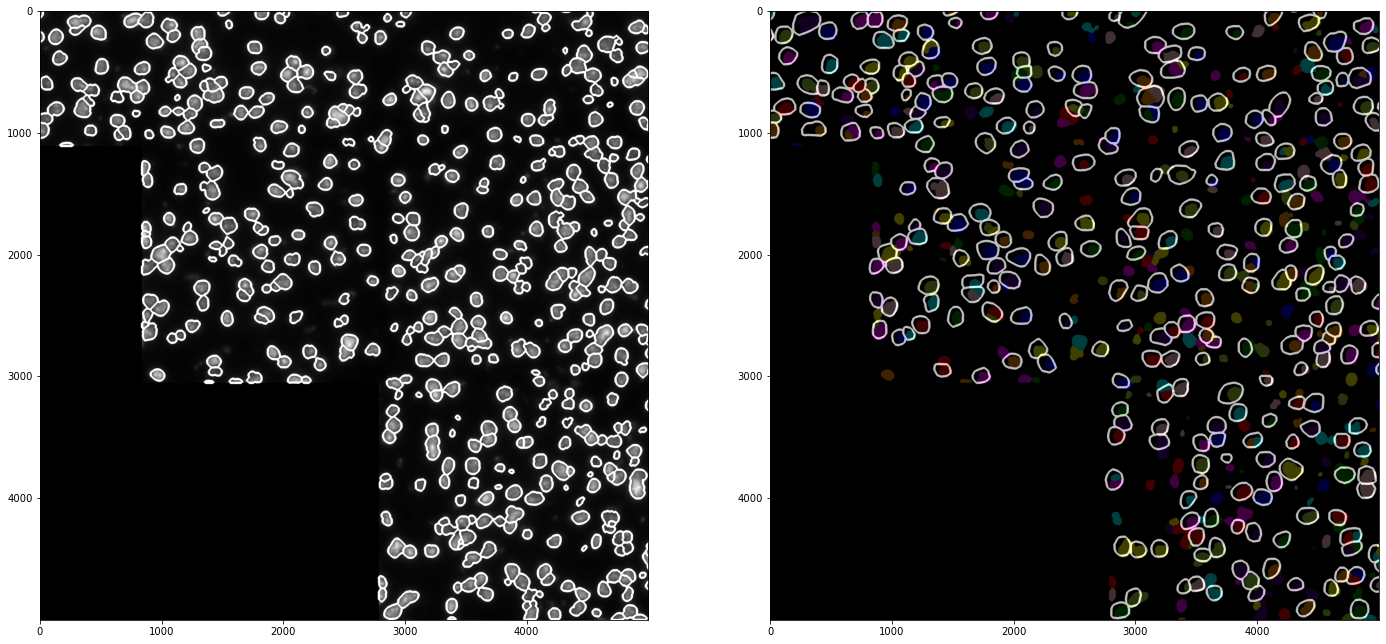

In [5]:
def add_contours(labels, img):
    c = contours_from_labels(labels, thickness=10)
    #return add_red_contours(img, c)
    tmp = numpy.copy(img)
    tmp[c]=numpy.max(img)
    return tmp

fig, axes = plt.subplots(ncols=2, figsize=(24,24))
axes[0].imshow(add_contours(oleh_img[-5000:,5000:10000], raw_img[-5000:,5000:10000]), cmap='gray')

axes[1].imshow(skimage.color.label2rgb(oleh_img[-5000:,5000:10000],
                                    contours_from_labels(gt_img[-5000:,5000:10000], 10),
                                    alpha=0.25,
                                    bg_label=0))

In [6]:
raw_small = skimage.transform.rescale(raw_img, scale=0.125,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
gt_small = skimage.transform.rescale(gt_img, scale=0.125,
                                     order=0, 
                                     clip=True, preserve_range=True).astype(numpy.uint16)
oleh_small = skimage.transform.rescale(oleh_img, scale=0.125,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
skimage.io.imsave("raw_small.tif", raw_small, plugin=None, check_contrast=True)
skimage.io.imsave("gt_small.tif", gt_small, plugin=None, check_contrast=True)
skimage.io.imsave("oleh_small.tif", oleh_small, plugin=None, check_contrast=True)

<ipython-input-6-a596f5b1b061>:10: UserWarning: raw_small.tif is a low contrast image
  skimage.io.imsave("raw_small.tif", raw_small, plugin=None, check_contrast=True)
<ipython-input-6-a596f5b1b061>:11: UserWarning: gt_small.tif is a low contrast image
  skimage.io.imsave("gt_small.tif", gt_small, plugin=None, check_contrast=True)


In [7]:
raw_medium = skimage.transform.rescale(raw_img, scale=0.25,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
gt_medium = skimage.transform.rescale(gt_img, scale=0.25,
                                     order=0, 
                                     clip=True, preserve_range=True).astype(numpy.uint16)
oleh_medium = skimage.transform.rescale(oleh_img, scale=0.25,
                                      order=0, 
                                      clip=True, preserve_range=True).astype(numpy.uint16)
skimage.io.imsave("raw_medium.tif", raw_medium, plugin=None, check_contrast=True)
skimage.io.imsave("gt_medium.tif", gt_medium, plugin=None, check_contrast=True)
skimage.io.imsave("oleh_medium.tif", oleh_medium, plugin=None, check_contrast=True)

<ipython-input-7-3bf0e141ff53>:10: UserWarning: raw_medium.tif is a low contrast image
  skimage.io.imsave("raw_medium.tif", raw_medium, plugin=None, check_contrast=True)
<ipython-input-7-3bf0e141ff53>:11: UserWarning: gt_medium.tif is a low contrast image
  skimage.io.imsave("gt_medium.tif", gt_medium, plugin=None, check_contrast=True)


(2688, 2688)
(2688, 2688)
(2688, 2688)
(2688, 2688)


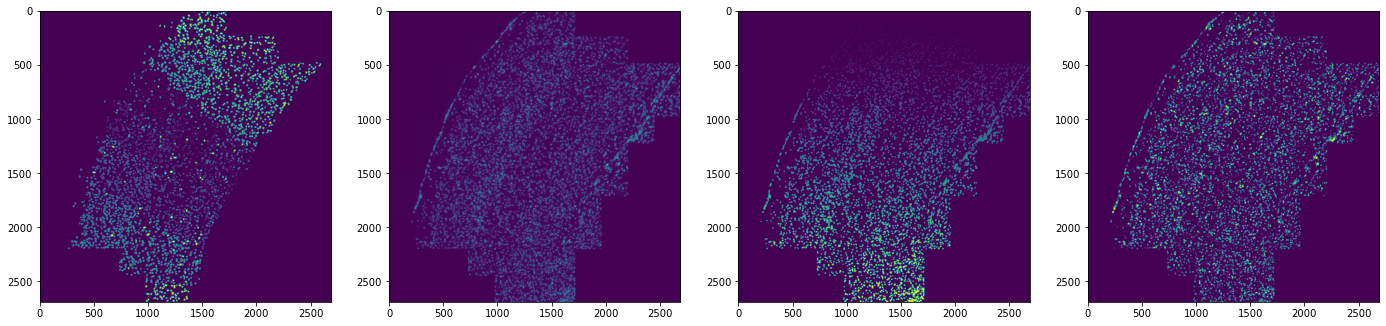

In [9]:
print(gt_small.shape)
print(raw_small.shape)
print(luca_small.shape)
print(oleh_small.shape)

fig, axes = plt.subplots(ncols=4, figsize=(24,24))
axes[0].imshow(gt_small)
axes[1].imshow(raw_small)
axes[2].imshow(luca_small)
axes[3].imshow(oleh_small)

### Upsample luca's labels to match size of Oleh's labels 

In [16]:
luca_img = skimage.transform.resize(luca_small, oleh_img.shape,
                                    order=0, 
                                    clip=True, preserve_range=True).astype(numpy.uint16)
print(luca_img.shape, luca_img.dtype)

(21505, 21505) uint16


In [17]:
luca_small_torch = torch.from_numpy(luca_small.astype(numpy.int32))
luca_img_torch = torch.from_numpy(luca_img.astype(numpy.int32))
oleh_img_torch = torch.from_numpy(oleh_img.astype(numpy.int32))

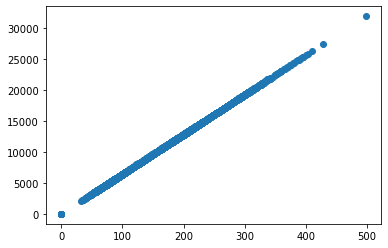

In [18]:
# Compute the areas and check nothing went worng during upsampling
luca_small_cells_area = torch.bincount(luca_small_torch.flatten())[1:]
luca_large_cells_area = torch.bincount(luca_img_torch.flatten())[1:]
oleh_large_cells_area = torch.bincount(oleh_img_torch.flatten())[1:]

plt.scatter(luca_small_cells_area,luca_large_cells_area)

### Save both segmentation with red contours 

In [ ]:
# make_and_save_segmentation(file_name="tmp.tiff", 
#                            labels=luca_labels[10000:11000,10000:11000], 
#                            raw_image=raw_img[10000:11000,10000:11000])

In [ ]:
# make_and_save_segmentation(file_name="luca_segmentation.tiff", 
#                            labels=luca_labels, 
#                            raw_image=raw_img)

In [ ]:
# make_and_save_segmentation(file_name="oleh_segmentation.tiff", 
#                            labels=oleh_labels, 
#                            raw_image=raw_img)

# Start the actual comparison

Based on:
1. luca_labels vs oleh_labels
2. luca_cells_area vs oleh_cells_area 

In [ ]:
ROI_mask = skimage.morphology.convex_hull_image(luca_labels > 0)
#plt.imshow(ROI_mask)

In [ ]:
window = make_list_of_windows(ROI_mask, n=4, crop_size=800)
plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(12,24))

In [ ]:
print("total segmented area: luca, oleh", luca_cells_area.sum(), oleh_cells_area.sum())

fig, ax = plt.subplots(figsize=(12,6))
ax.set_xlabel("cells area")
_ = ax.hist([luca_cells_area,oleh_cells_area], bins=50,label=["luca","oleh"])
_ = ax.legend()
fig.savefig("histo.png", dpi=300)

In [ ]:
float(luca_cells_area.shape[0]) / oleh_cells_area.shape[0]

In [ ]:
ratio_ol = float(oleh_cells_area.sum())/luca_cells_area.sum()
ratio_lo = float(luca_cells_area.sum())/oleh_cells_area.sum()
print(ratio_ol, ratio_lo)

In [ ]:
oleh_cells_area.sum()

In [ ]:
luca_cells_area.sum()

In [ ]:
window = [(8*1000, 8*2100, 8*1300, 8*2400)]
#window = [(8*1000, 8*2100, 8*1100, 8*2200)]

plot_comparison(raw_img, luca_labels, oleh_labels, window=window, figsize=(24,24))

### Compute intersection over union

In [19]:
luca_labels = luca_img
oleh_labels = oleh_img

import torch 
window = (8*1000, 8*2100, 8*1300, 8*2400)
window = (8*1000, 8*2100, 8*1100, 8*2200)
window = (0,0,luca_labels.shape[0],luca_labels.shape[1])

size = window[2]-window[0]
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

luca_membership = torch.from_numpy(luca_labels[window[0]:window[2],window[1]:window[3]].astype(int)).flatten().to(device)
oleh_membership = torch.from_numpy(oleh_labels[window[0]:window[2],window[1]:window[3]].astype(int)).flatten().to(device)
luca_sizes = torch.bincount(luca_membership)
oleh_sizes = torch.bincount(oleh_membership)

In [20]:
luca_sizes

tensor([413325585,     20544,      8704,  ...,      5696,      3136,
             4032])

In [ ]:
sizes, membership = Partition.compactify(luca_sizes, luca_membership)
luca_partition = Partition(which="luca",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

sizes, membership = Partition.compactify(oleh_sizes, oleh_membership)
oleh_partition = Partition(which="oleh",
                           membership=membership, # bg=0, fg=1,2,3,.....
                           sizes=sizes,
                           params={"ciap":"ciao"})

In [ ]:
plt.imshow(oleh_partition.membership.view(size,size))

In [ ]:
plt.imshow(luca_partition.membership.view(size,size))

In [ ]:
c = luca_partition.concordance_with_partition(oleh_partition) 

In [ ]:
c.iou

In [ ]:
plt.imshow(luca_partition.membership.view(size,size)==1)

In [ ]:
c

In [ ]:
torch.max(pxy)

In [ ]:
plt.matshow(pxy[1:,1:].T, cmap='gray')

In [ ]:
c_ol = oleh_partition.concordance_with_partition(luca_partition) 

In [ ]:
c_lo = luca_partition.concordance_with_partition(oleh_partition) 

In [ ]:
c_ol.iou

In [ ]:
c_lo.iou

In [ ]:
plt.imshow(oleh_partition.membership.view(size,size))

In [ ]:
plt.imshow(luca_partition.membership.view(size,size))